<a href="https://colab.research.google.com/github/GaneshReddy2232/DauNet/blob/main/DauNet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download safurahajiheidari/kidney-stone-images

Dataset URL: https://www.kaggle.com/datasets/safurahajiheidari/kidney-stone-images
License(s): other


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/kidney-stone-images.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [8]:
DATADIR = '/content/KidneyDisease'
CATEGORIES = ['TestImages', 'TrainImages', 'ValidImages']
IMG_SIZE = 224

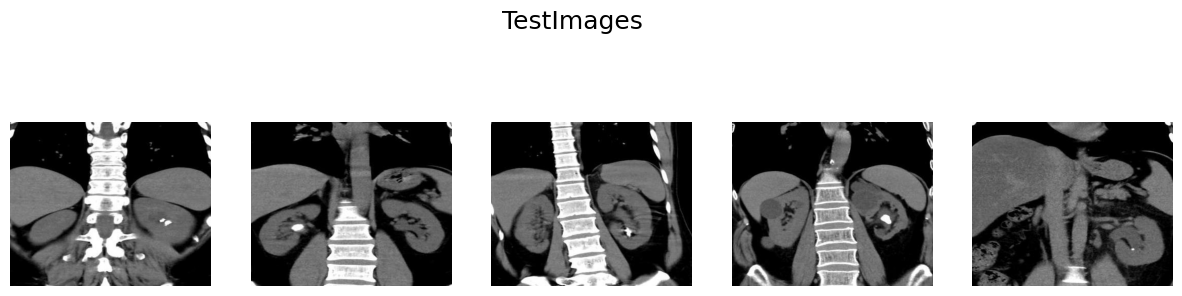

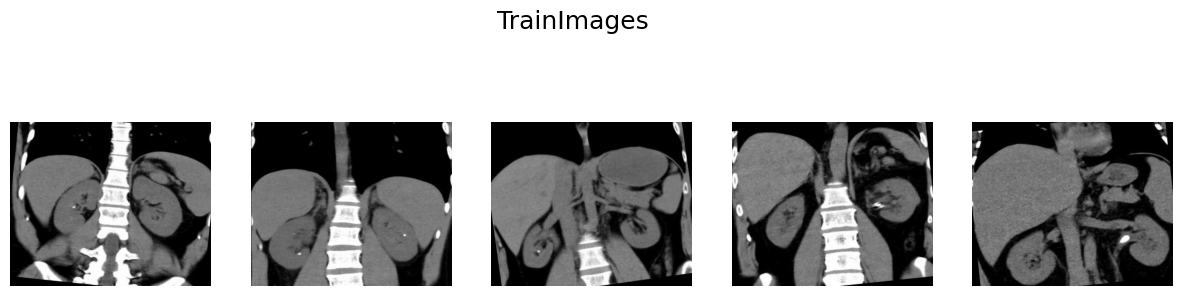

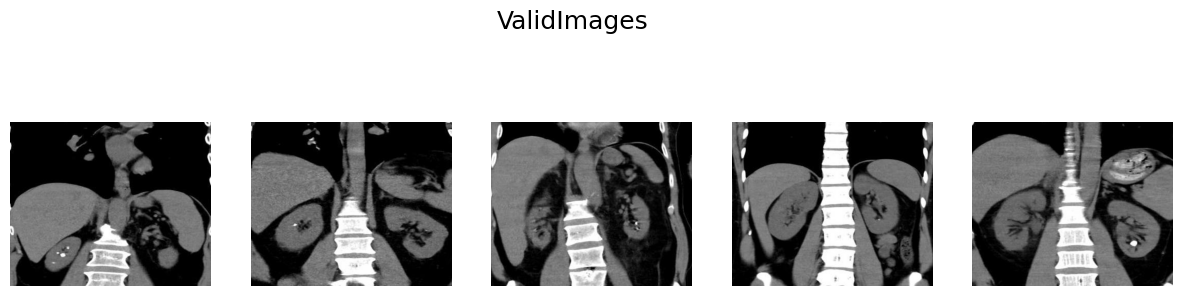

In [9]:
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    images = os.listdir(path)
    fig, axes = plt.subplots(1, 5, figsize=(15, 4))
    fig.suptitle(f'{category}', fontsize=18)
    for i in range(5):
        img_name = images[np.random.randint(0, len(images))]
        img_path = os.path.join(path, img_name)
        img_array = cv2.imread(img_path)
        axes[i].imshow(img_array)
        axes[i].axis('off')
    plt.show()

In [11]:
training_data = []
def create_train_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        labels = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_array = cv2.imread(img_path)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, labels])
            except Exception as e:
                pass

create_train_data()

x = np.array([features for features, labels in training_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array([labels for features, labels in training_data])

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [13]:
x_train_torch = torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
y_train_torch = torch.tensor(y_train, dtype=torch.long)
x_test_torch = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
y_test_torch = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(x_train_torch, y_train_torch)
test_dataset = TensorDataset(x_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
class DauNet(nn.Module):
    def __init__(self):
        super(DauNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 512)
        self.fc2 = nn.Linear(512, len(CATEGORIES))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DauNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs} - Average Loss: {avg_loss:.4f}")

Epoch 1/20 - Average Loss: 0.7867
Epoch 2/20 - Average Loss: 0.4429
Epoch 3/20 - Average Loss: 0.2286
Epoch 4/20 - Average Loss: 0.1416
Epoch 5/20 - Average Loss: 0.0797
Epoch 6/20 - Average Loss: 0.0393
Epoch 7/20 - Average Loss: 0.0312
Epoch 8/20 - Average Loss: 0.0165
Epoch 9/20 - Average Loss: 0.0172
Epoch 10/20 - Average Loss: 0.0148
Epoch 11/20 - Average Loss: 0.0022
Epoch 12/20 - Average Loss: 0.0009
Epoch 13/20 - Average Loss: 0.0053
Epoch 14/20 - Average Loss: 0.0039
Epoch 15/20 - Average Loss: 0.0045
Epoch 16/20 - Average Loss: 0.0027
Epoch 17/20 - Average Loss: 0.0001
Epoch 18/20 - Average Loss: 0.0001
Epoch 19/20 - Average Loss: 0.0000
Epoch 20/20 - Average Loss: 0.0000


Test Accuracy: 90.77%


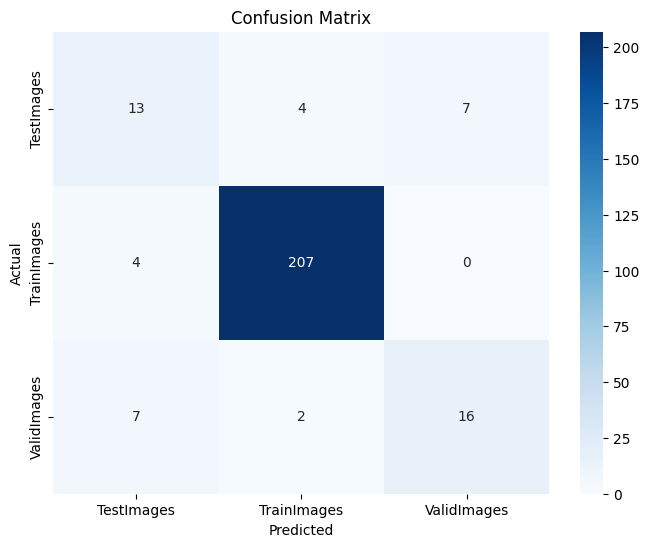

              precision    recall  f1-score   support

  TestImages       0.54      0.54      0.54        24
 TrainImages       0.97      0.98      0.98       211
 ValidImages       0.70      0.64      0.67        25

    accuracy                           0.91       260
   macro avg       0.74      0.72      0.73       260
weighted avg       0.91      0.91      0.91       260



In [19]:
model.eval()
y_pred, y_true = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(y_true, y_pred, target_names=CATEGORIES))

In [24]:
torch.save(model.state_dict(), "dauNet_trained.pth")
print("Model saved successfully!")

Model saved successfully!


In [25]:
# Load model
model = DauNet().to(device)
model.load_state_dict(torch.load("dauNet_trained.pth"))
model.eval()
print("Model loaded successfully!")

Model loaded successfully!


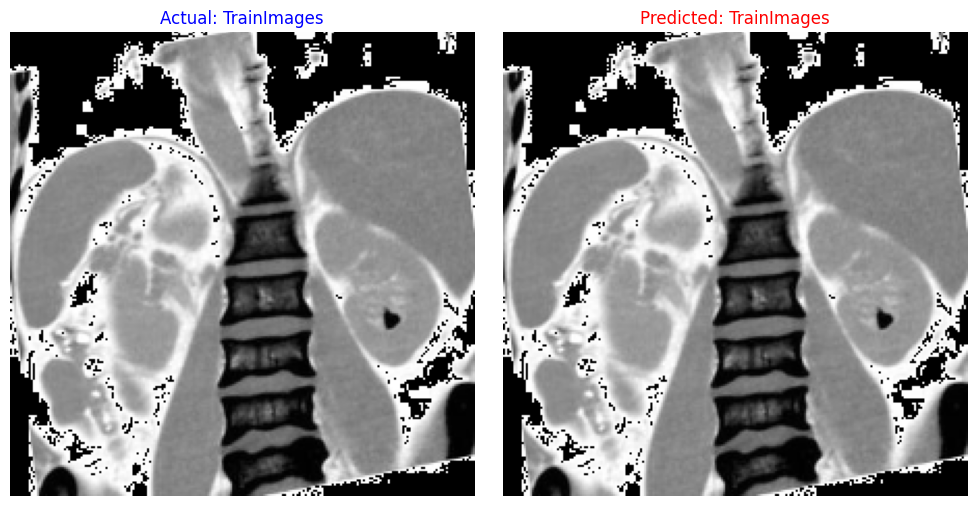

In [26]:
def test_image(img, label):
    img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
    img_tensor = img_tensor.to(device)

    # Predict
    output = model(img_tensor)
    class_idx = torch.argmax(output).item()
    predicted_label = CATEGORIES[class_idx]

    # Show results
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(np.uint8(img * 255))
    ax[0].set_title(f"Actual: {CATEGORIES[label]}", fontsize=12, color='blue')
    ax[0].axis("off")

    if predicted_label == "Stone Present":
        bbox = [50, 50, 100, 100]  # Example box, replace with actual detected area
        output_image = draw_bounding_box(np.uint8(img * 255), bbox, "Stone")
    else:
        output_image = np.uint8(img * 255)

    ax[1].imshow(output_image)
    ax[1].set_title(f"Predicted: {predicted_label}", fontsize=12, color='red')
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

# Test any image after training
i = 4  # Change this to test a different image
test_image(x_test[i], y_test[i])

✅ The scan is **normal**. No stone detected.


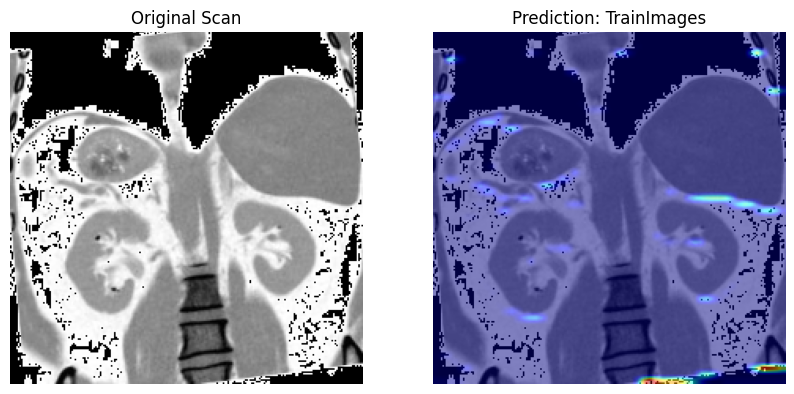

In [29]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, class_idx):
        self.model.eval()  # Ensure model is in eval mode
        output = self.model(input_tensor)
        self.model.zero_grad()
        target = output[0, class_idx]
        target.backward()

        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).squeeze()
        cam = torch.clamp(cam, min=0).cpu().numpy()
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

def apply_heatmap(image, cam):
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)
    return overlay

# Load Image and Process It
target_layer = model.conv3  # Ensure this is the last conv layer
img = x_test[0]
img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
img_tensor = img_tensor.to(device)

# Get Prediction
model.eval()
output = model(img_tensor)
class_idx = torch.argmax(output).item()

# Check if the model detected a stone or not
predicted_label = CATEGORIES[class_idx]  # Assuming CATEGORIES = ["Normal", "Stone"]

if predicted_label.lower() == "stone":
    print("⚠️ The model detected a **kidney stone** in this image.")
else:
    print("✅ The scan is **normal**. No stone detected.")

# Generate Grad-CAM
grad_cam = GradCAM(model, target_layer)
cam = grad_cam.generate_cam(img_tensor, class_idx)

# Apply Heatmap to Original Image
original_image = np.uint8(img * 255)  # Ensure image is in 0-255 format
overlay_image = apply_heatmap(original_image, cam)

# Show Result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Scan")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay_image)
plt.title(f"Prediction: {predicted_label}")
plt.axis("off")

plt.show()

Image 1: ✅ Normal scan. No stone detected.
Image 2: ✅ Normal scan. No stone detected.
Image 3: ✅ Normal scan. No stone detected.
Image 4: ✅ Normal scan. No stone detected.
Image 5: ✅ Normal scan. No stone detected.


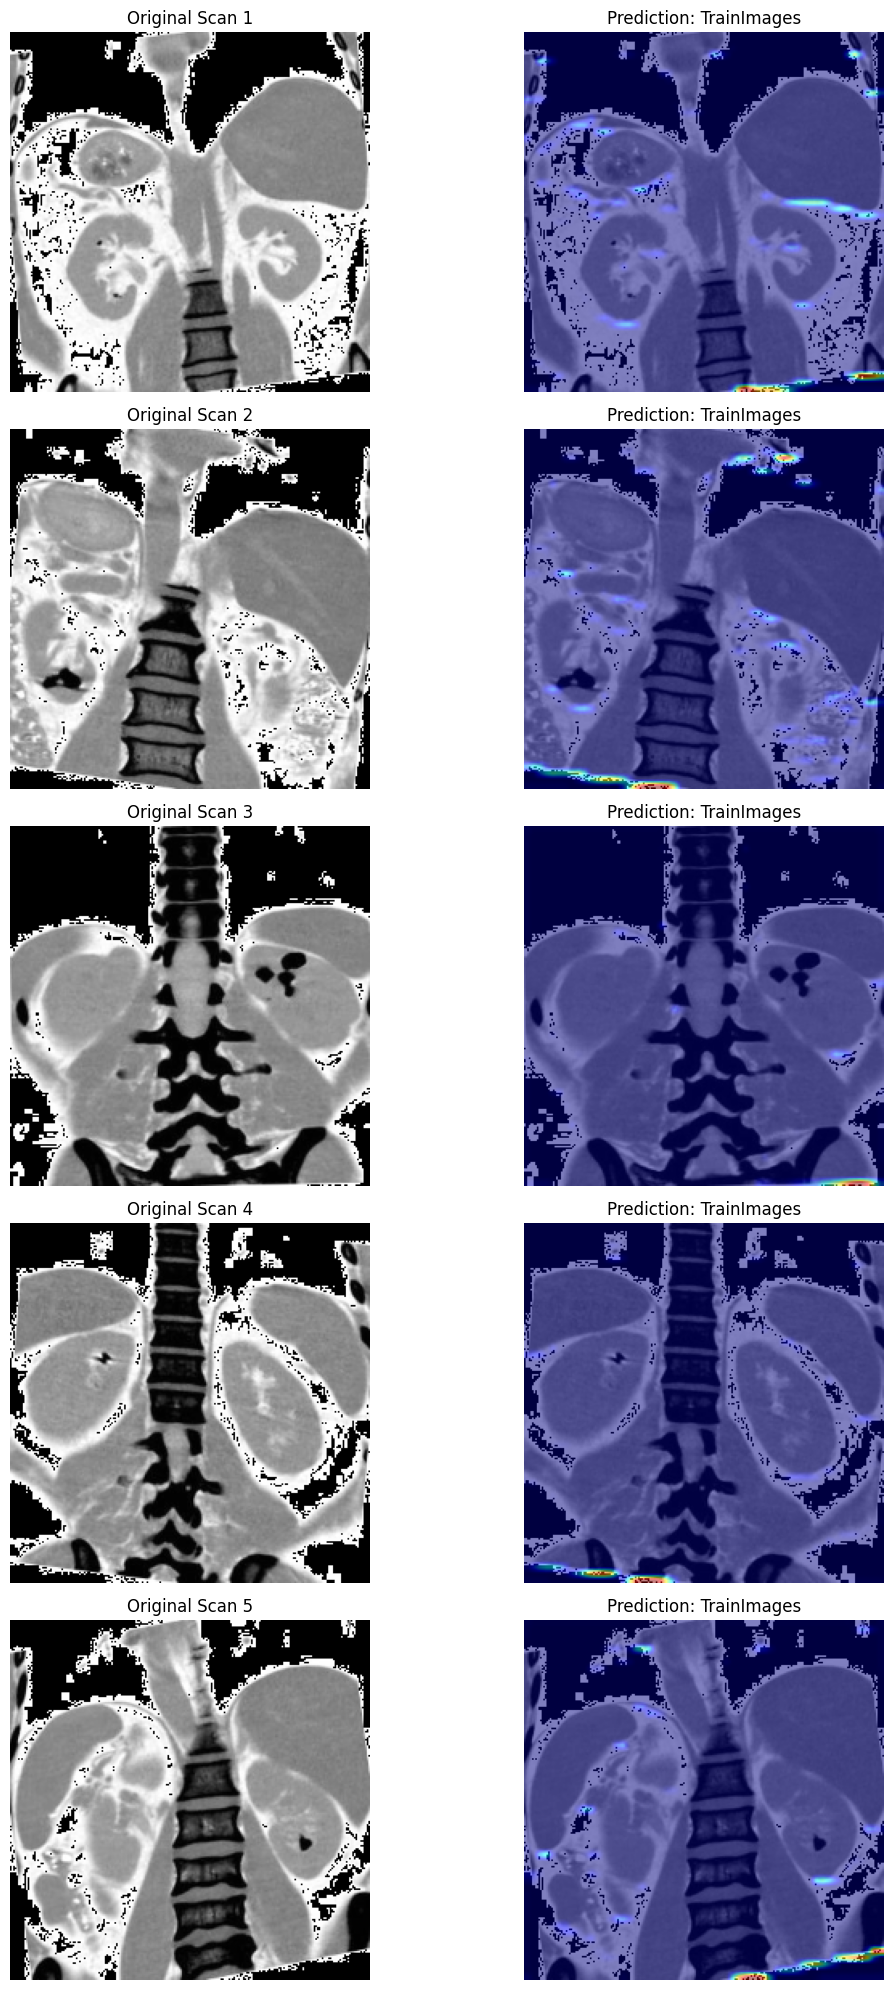

In [32]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, class_idx):
        self.model.eval()
        output = self.model(input_tensor)
        self.model.zero_grad()
        target = output[0, class_idx]
        target.backward()

        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).squeeze()
        cam = torch.clamp(cam, min=0).cpu().numpy()
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

def apply_heatmap(image, cam):
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)
    return overlay

# Select the number of test images to process
num_images = 5  # Change this number to process more images

target_layer = model.conv3  # Ensure this is the last conv layer
grad_cam = GradCAM(model, target_layer)

plt.figure(figsize=(12, num_images * 4))  # Adjust figure size based on the number of images

for i in range(num_images):
    img = x_test[i]
    img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
    img_tensor = img_tensor.to(device)

    # Get Prediction
    model.eval()
    output = model(img_tensor)
    class_idx = torch.argmax(output).item()

    # Check if the model detected a stone or not
    predicted_label = CATEGORIES[class_idx]  # Assuming CATEGORIES = ["Normal", "Stone"]

    if predicted_label.lower() == "stone":
        print(f"Image {i+1}: ⚠️ Kidney stone detected.")
    else:
        print(f"Image {i+1}: ✅ Normal scan. No stone detected.")

    # Generate Grad-CAM
    cam = grad_cam.generate_cam(img_tensor, class_idx)

    # Apply Heatmap to Original Image
    original_image = np.uint8(img * 255)
    overlay_image = apply_heatmap(original_image, cam)

    # Show Original and Heatmap Images Side by Side
    plt.subplot(num_images, 2, 2*i+1)
    plt.imshow(original_image)
    plt.title(f"Original Scan {i+1}")
    plt.axis("off")

    plt.subplot(num_images, 2, 2*i+2)
    plt.imshow(overlay_image)
    plt.title(f"Prediction: {predicted_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()